In [ ]:
import os, time
import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
# import sys, pickle, warnings
# import matplotlib.pyplot as plt
# import seaborn as sns

cwd = os.getcwd()

from model import CNSBM
from model import CNSBMTrainer
from model.utils_cnsbm import plt_blocks

# 0. Functions

In [2]:
def generate_pi(K, L, num_cat, concentration=0.9, num_dominant=1):
    """
    Generate a probability tensor of shape (K, L, num_cat)
    with most mass concentrated on `num_dominant` categories using a Dirichlet distribution.

    Parameters:
    - K: First dimension size
    - L: Second dimension size
    - num_cat: Number of categories
    - concentration: Total probability mass to assign to dominant categories (default: 0.9)
    - num_dominant: Number of dominant categories (1, 2, or 3)

    Returns:
    - A tensor of shape (K, L, num_cat) representing probability distributions.
    """
    # assert 1 <= num_dominant <= min(3, num_cat), "num_dominant must be between 1 and min(3, num_cat)"
    
    # Initialize probability tensor
    pi = np.zeros((K, L, num_cat))
    
    for k in range(K):
        for l in range(L):
            # Choose `num_dominant` unique dominant categories
            dominant_categories = np.random.choice(num_cat, num_dominant, replace=False)
            
            # Distribute the concentration mass equally among dominant categories
            dominant_mass = concentration / num_dominant
            dirichlet_weights = np.full(num_cat, (1 - concentration) / (num_cat - num_dominant))
            dirichlet_weights[dominant_categories] = dominant_mass
            
            # Sample from a Dirichlet centered around dirichlet_weights
            pi[k, l, :] = np.random.dirichlet(dirichlet_weights * 100)
    
    return pi

# 1. Simulated Data

In [3]:
N, M = 500, 200
K, L = 15, 10

# Generate cluster assignments
g = np.random.choice(K, size=N)
h = np.random.choice(L, size=M)

# Generate categories
num_cat = 13
categories = list(range(num_cat))

# Generate the probability vectors
# pi = generate_pi(K, L, num_cat, concentration=0.6)
pi = generate_pi(K, L, num_cat, concentration=0.6, num_dominant=1)

# Iterate over clusters instead of individual indices
C = np.zeros((N, M), dtype=int)
for k in range(K):
    for l in range(L):
        # Get indices of rows and columns belonging to cluster k and l
        rows = np.where(g == k)[0]
        cols = np.where(h == l)[0]

        # Sample values for this cluster pair
        sampled_values = np.random.choice(categories, size=(len(rows), len(cols)), p=pi[k, l])

        # Assign to corresponding block in matrix C
        for i, row in enumerate(rows):
            C[row, cols] = sampled_values[i, :]


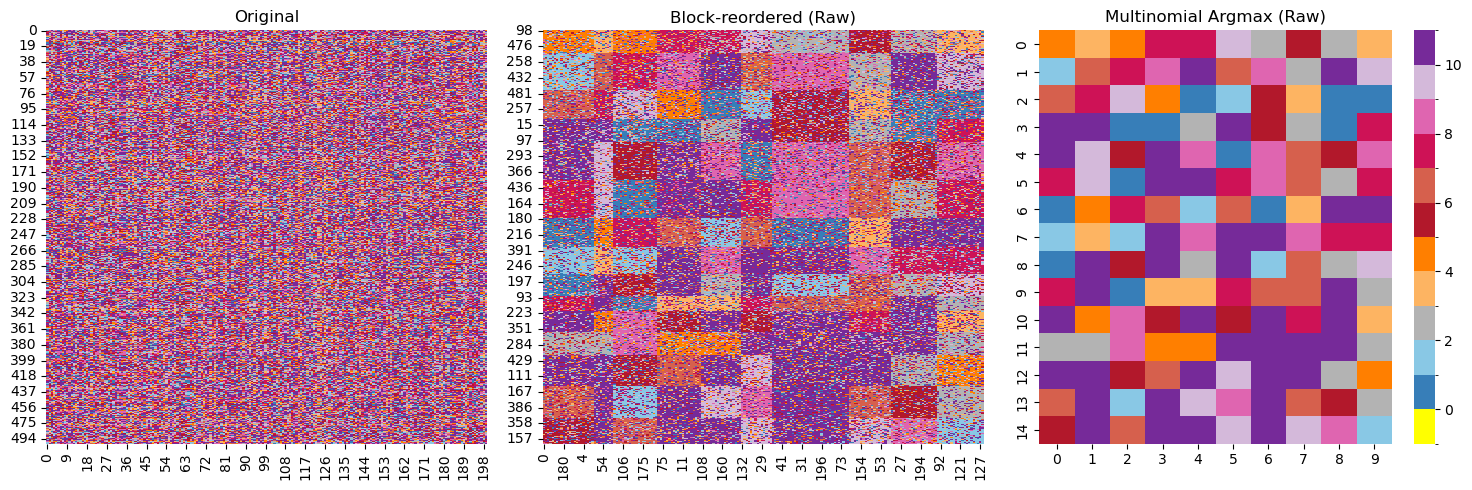

In [4]:
# plot raw and reordered data
cluster_means = np.array(jnp.argmax(pi, axis=2))
plt_blocks(C, g, h, cluster_means, ' (Raw)', print_labels=False)

# 1. Batch Variational Inference (CAVI)

In [5]:
# convert to jax array
C = jnp.asarray(C)

Initializing variational distributions (seed 43)...
Running batch variational inference...
Iteration 0, ELBO: -248,114.188, Loglik: -245,868.125, KL-g: 813.478, KL-h: 314.236, KL-kl: 1,118.336
Time elapsed: 0.10 seconds
Iteration 1, ELBO: -217,921.453, Loglik: -215,053.938, KL-g: 1,042.547, KL-h: 371.371, KL-kl: 1,453.594
Time elapsed: 0.09 seconds
Iteration 2, ELBO: -210,491.219, Loglik: -207,525.781, KL-g: 1,025.572, KL-h: 382.548, KL-kl: 1,557.306
Time elapsed: 0.09 seconds
Iteration 3, ELBO: -210,276.984, Loglik: -207,333.469, KL-g: 1,020.373, KL-h: 382.548, KL-kl: 1,540.591
Time elapsed: 0.10 seconds
Iteration 4, ELBO: -210,253.562, Loglik: -207,346.719, KL-g: 1,018.287, KL-h: 382.548, KL-kl: 1,506.011
Time elapsed: 0.10 seconds
Iteration 5, ELBO: -210,215.578, Loglik: -207,326.688, KL-g: 1,016.619, KL-h: 382.548, KL-kl: 1,489.723
Time elapsed: 0.10 seconds
Iteration 6, ELBO: -210,215.578, Loglik: -207,326.688, KL-g: 1,016.619, KL-h: 382.548, KL-kl: 1,489.723
Time elapsed: 0.09 se

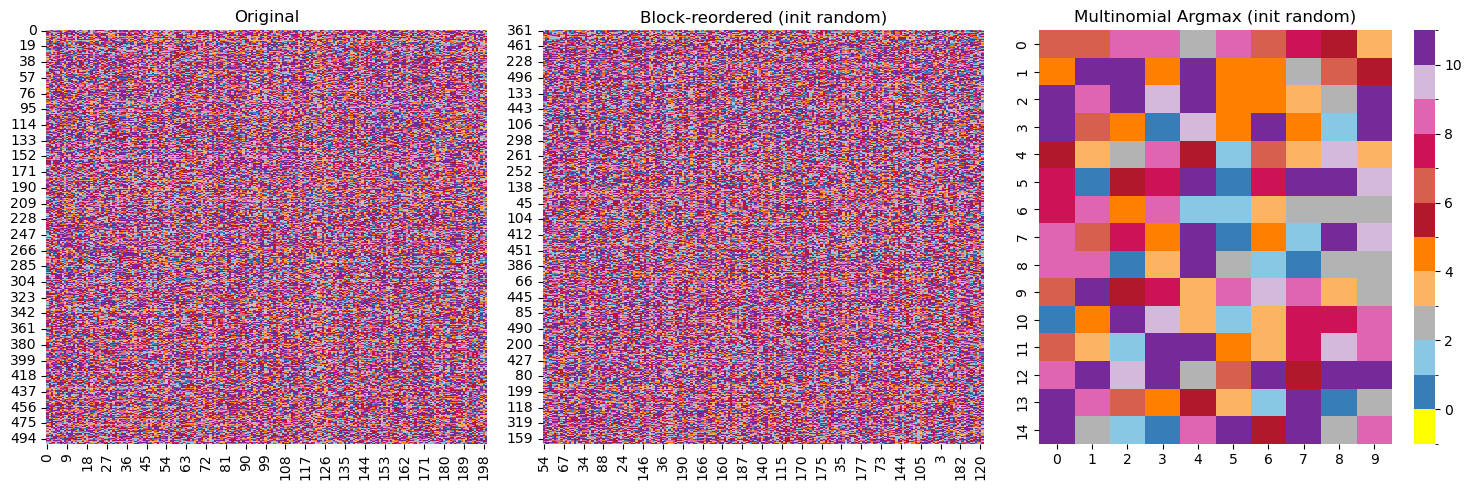

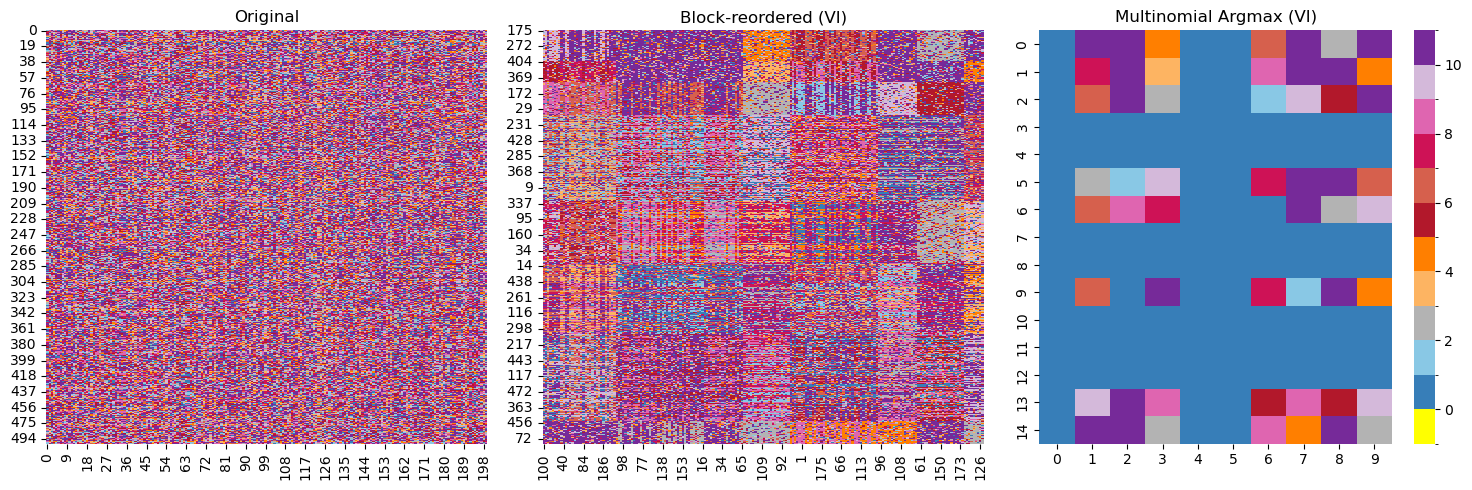

ELBO: -210,215.578, Loglik: -207,326.688, KL-g: 1,016.619, KL-h: 382.548, KL-kl: 1,489.723
8 row clusters: [ 0  1  2  5  6  9 13 14]
7 col clusters: [1 2 3 6 7 8 9]
Rows with <0.5 probability: 0
Cols with <0.5 probability: 0
Rows with <0.75 probability: 0
Cols with <0.75 probability: 0
Rows with <0.9 probability: 0
Cols with <0.9 probability: 0
Rows with <0.95 probability: 0
Cols with <0.95 probability: 0
Rows with <1 probability: 0
Cols with <1 probability: 0
ICL: -212,242.609, Loglik: -207,001.172, ICL-penalty: 3,905.989, g-entr: -973.903, h-entr: -361.546, K-eff: 8, L-eff: 7
Time elapsed: 1.57 seconds, initialization: 0.00, fitting: 1.57, 


In [18]:
start_time = time.time()
K, L = 15, 10

# we recommend rand_init='spectral_bi'
start_time1 = time.time()
sbm_test = CNSBM(C, K, L, rand_init='random', fill_na=2, seed=43)
end_time1 = time.time()
start_time2 = time.time()
_ = sbm_test.batch_vi(75, batch_print=1, fitted=False, tol=1e-6)
end_time = time.time()

sbm_test.plt_blocks(plt_init=True)
sbm_test.summary()
_ = sbm_test.ICL(verbose=True, slow=True)

print(f"Time elapsed: {end_time - start_time:,.2f} seconds, initialization: {end_time1-start_time1:,.2f}, fitting: {end_time-start_time2:,.2f}, ")

In [19]:
# save outputs
os.makedirs(os.path.join(cwd, 'output'), exist_ok=True)
sbm_test.export_outputs_csv(os.path.join(cwd, 'output'), model_name='test_sbm')
sbm_test.save_jax_model(os.path.join(cwd, 'output', f'test_sbm.pickle'))

Saving model...


In [13]:
# # Stochastic VI version
# start_time = time.time()
# K, L = 15, 10

# batch_size=(100, 200)
# int(N*M/(batch_size[0]*batch_size[1]))

# start_time1 = time.time()
# sbm_test = CNSBM(C, K, L, rand_init='spectral_bi', fill_na=2)
# end_time1 = time.time()
# start_time2 = time.time()
# _ = sbm_test.stochastic_vi(
#     num_iters=75, batch_size=(100, 200), batch_print=1, local_max_iters=2, local_tol=5e-4,
#     eta_0=0.1, tau=1, kappa=0.9, batches_per_epoch=int(N*M/(batch_size[0]*batch_size[1])), tol=1e-6,
#     fitted=False, update_ind=True, scheduler='svi', elbo_batch_size=None)
# end_time = time.time()

# # sbm_test.plt_blocks(plt_init=True)
# sbm_test.summary()
# _ = sbm_test.ICL(verbose=True, slow=True)

# print(f"Time elapsed: {end_time - start_time:,.2f} seconds, initialization: {end_time1-start_time1:,.2f}, fitting: {end_time-start_time2:,.2f}, ")

# 2. Exploring Additional Clusters

In [20]:
max_iter=20
max_switch=6
empty_threshold=1e-6
split_threshold=0.4
entr_threshold=0.2
concentration=0.8 # for parameter warm starts

multi_split=True
verbose=False
max_vi_iter=100 # maximum iterations per CNSBM run
vi_batch_print=10 # when to print

max_patience=10

In [21]:
# 2. Fill clusters if possible (using multiple strategies starting from the initial model
# Explore better models by filling empty clusters
sbm_trainer = CNSBMTrainer(sbm_test)
sbm_trainer.fill_clusters(
    max_iter=max_iter, max_switch=max_switch, empty_threshold=empty_threshold, split_threshold=split_threshold, entr_threshold=entr_threshold, concentration=concentration,
    multi_split=multi_split, verbose=verbose, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print, fill_strategy='spectral', alt_fill_strategy='spectral'
)
sbm_trainer.clear_model_cache()

sbm_trainer.fill_clusters(
    max_iter=max_iter, max_switch=max_switch, empty_threshold=empty_threshold, split_threshold=split_threshold, entr_threshold=entr_threshold, concentration=concentration,
    multi_split=multi_split, verbose=verbose, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print, fill_strategy='random', alt_fill_strategy='spectral'
)
sbm_trainer.clear_model_cache()

sbm_trainer.fill_clusters(
    max_iter=max_iter, max_switch=max_switch, empty_threshold=empty_threshold, split_threshold=split_threshold, entr_threshold=entr_threshold, concentration=concentration,
    multi_split=multi_split, verbose=verbose, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print, fill_strategy='max_split', alt_fill_strategy='spectral'
)
sbm_trainer.clear_model_cache()

sbm_trainer.fill_clusters(
    max_iter=max_iter, max_switch=max_switch, empty_threshold=empty_threshold, split_threshold=split_threshold, entr_threshold=entr_threshold, concentration=concentration,
    multi_split=multi_split, verbose=verbose, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print, fill_strategy='spectral_bi', alt_fill_strategy='spectral'
)
sbm_trainer.clear_model_cache()

# 3. Reduce clusters where possible
# # remove min sample clusters
sbm_trainer.select_model_version(select_best=True, verbose=True)
sbm_trainer.reset_min_clusters(2, 2, concentration=concentration, direction='row', max_iter=5, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print) # 1 sample clusters
sbm_trainer.clear_model_cache()

sbm_trainer.select_model_version(select_best=True, verbose=True)
sbm_trainer.reset_min_clusters(5, 5, concentration=concentration, direction='row', max_iter=max_iter, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print) # <4 sample clusters
sbm_trainer.clear_model_cache()

sbm_trainer.select_model_version(select_best=True, verbose=True)
sbm_trainer.reset_min_clusters(10, 10, concentration=concentration, direction='row', max_iter=max_iter, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print) # <9 sample clusters
sbm_trainer.clear_model_cache()

# remove duplicated clusters
sbm_trainer.select_model_version(select_best=True, verbose=True)
sbm_trainer.reset_duplicated_clusters(max_iter=max_iter, concentration=concentration, empty_threshold=empty_threshold, max_patience=max_patience, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print)
sbm_trainer.clear_model_cache()

sbm_trainer.select_model_version(select_best=True, verbose=True)
sbm_trainer.reset_duplicated_clusters(max_iter=max_iter, concentration=concentration, empty_threshold=empty_threshold, max_patience=max_patience, max_vi_iter=max_vi_iter, vi_batch_print=vi_batch_print,
                                      direction='row')
sbm_trainer.clear_model_cache()




Iteration 0

Mean row entropy: 0.828 | Mean col entropy: 0.869
Cluster Impurities: Row [0, 1, 2, 5, 6, 9, 13, 14], Col [1, 2, 3, 6, 7, 8, 9]

Empty rows: 7 | Empty cols: 3 / Duplicated rows: 6 | Duplicated cols: 2
Single plitting style: empty row
Available rows/cols to fill: rows [3, 4, 7, 8, 10, 11, 12] | cols [0, 4, 5]


/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:131: RuntimeWarning: invalid value encountered in divide
  vectors = vectors / np.sqrt((vectors**2).sum(axis=1))[:, np.newaxis]
/Users/kevinlam/GitHub/PhD/cpl/cnsbm_mlcb/model/utils_trainer.py:132: UserWarning: Iteration 0: Error in cluster assignment, skipping to next...
  warnings.warn(f"Iteration {i}: Error in cluster assignment, skipping to next...")
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizi

/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:131: RuntimeWarning: invalid value encountered in divide
  vectors = vectors / np.sqrt((vectors**2).sum(axis=1))[:, np.newaxis]
/Users/kevinlam/GitHub/PhD/cpl/cnsbm_mlcb/model/utils_trainer.py:132: UserWarning: Iteration 5: Error in cluster assignment, skipping to next...
  warnings.warn(f"Iteration {i}: Error in cluster assignment, skipping to next...")


SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizi

/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:131: RuntimeWarning: invalid value encountered in divide
  vectors = vectors / np.sqrt((vectors**2).sum(axis=1))[:, np.newaxis]
/Users/kevinlam/GitHub/PhD/cpl/cnsbm_mlcb/model/utils_trainer.py:132: UserWarning: Iteration 0: Error in cluster assignment, skipping to next...
  warnings.warn(f"Iteration {i}: Error in cluster assignment, skipping to next...")


SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizi

/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:131: RuntimeWarning: divide by zero encountered in divide
  vectors = vectors / np.sqrt((vectors**2).sum(axis=1))[:, np.newaxis]



Fitting Model ...
Initializing variational distributions (seed 44)...
Setting warm start updates for gammas...
Running batch variational inference...
Iteration 0, ELBO: -197,870.531, Loglik: -194,079.875, KL-g: 1,242.850, KL-h: 382.548, KL-kl: 2,165.261
Time elapsed: 0.12 seconds
Iteration 10, ELBO: -194,964.516, Loglik: -191,103.625, KL-g: 1,247.950, KL-h: 382.548, KL-kl: 2,230.390
Time elapsed: 0.09 seconds
Iteration 14, ELBO: -194,964.516, Loglik: -191,103.625, KL-g: 1,247.950, KL-h: 382.548, KL-kl: 2,230.391
ELBO converged at iteration 14.
Old ELBO: -197,746.234 | New ELBO: -194,964.516
ELBO improved, keeping new model and current priority...

Iteration 2

Mean row entropy: 0.795 | Mean col entropy: 0.746
Cluster Impurities: Row [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], Col [1, 2, 3, 6, 7, 8, 9]

Empty rows: 2 | Empty cols: 3 / Duplicated rows: 2 | Duplicated cols: 2
Single plitting style: empty row
Available rows/cols to fill: rows [1, 3] | cols [0, 4, 5]
SVD did not converge

/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:131: RuntimeWarning: invalid value encountered in divide
  vectors = vectors / np.sqrt((vectors**2).sum(axis=1))[:, np.newaxis]
/Users/kevinlam/GitHub/PhD/cpl/cnsbm_mlcb/model/utils_trainer.py:132: UserWarning: Iteration 0: Error in cluster assignment, skipping to next...
  warnings.warn(f"Iteration {i}: Error in cluster assignment, skipping to next...")
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sk

Iteration 0, ELBO: -194,875.953, Loglik: -191,149.562, KL-g: 1,227.671, KL-h: 382.548, KL-kl: 2,116.173
Time elapsed: 0.12 seconds
Iteration 6, ELBO: -194,866.359, Loglik: -191,141.719, KL-g: 1,227.222, KL-h: 382.548, KL-kl: 2,114.870
ELBO converged at iteration 6.
Old ELBO: -194,964.516 | New ELBO: -194,866.359
ELBO improved, keeping new model and current priority...

Iteration 3

Mean row entropy: 0.795 | Mean col entropy: 0.765
Cluster Impurities: Row [0, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14], Col [1, 2, 3, 6, 7, 8, 9]

Empty rows: 3 | Empty cols: 3 / Duplicated rows: 2 | Duplicated cols: 2
Single plitting style: empty row
Available rows/cols to fill: rows [1, 3, 10] | cols [0, 4, 5]
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again
SVD did not converge, randomizing and trying again

/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:131: RuntimeWarning: invalid value encountered in divide
  vectors = vectors / np.sqrt((vectors**2).sum(axis=1))[:, np.newaxis]
/Users/kevinlam/GitHub/PhD/cpl/cnsbm_mlcb/model/utils_trainer.py:132: UserWarning: Iteration 0: Error in cluster assignment, skipping to next...
  warnings.warn(f"Iteration {i}: Error in cluster assignment, skipping to next...")
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sk

Iteration 0, ELBO: -194,922.562, Loglik: -191,167.078, KL-g: 1,231.258, KL-h: 382.548, KL-kl: 2,141.672
Time elapsed: 0.13 seconds
Iteration 6, ELBO: -194,866.359, Loglik: -191,141.719, KL-g: 1,227.222, KL-h: 382.548, KL-kl: 2,114.870
ELBO converged at iteration 6.
Old ELBO: -194,866.359 | New ELBO: -194,866.359
ELBO not improved, keeping old model | nr switches: 1

Iteration 4

Mean row entropy: 0.795 | Mean col entropy: 0.765
Cluster Impurities: Row [0, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14], Col [1, 2, 3, 6, 7, 8, 9]

Empty rows: 3 | Empty cols: 3 / Duplicated rows: 2 | Duplicated cols: 2
Single plitting style: empty col
Available rows/cols to fill: rows [1, 3, 10] | cols [0, 4, 5]


/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Fitting Model ...
Initializing variational distributions (seed 47)...
Setting warm start updates for gammas...
Running batch variational inference...
Iteration 0, ELBO: -177,955.203, Loglik: -173,349.625, KL-g: 1,227.222, KL-h: 466.747, KL-kl: 2,911.610
Time elapsed: 0.12 seconds
Iteration 6, ELBO: -177,694.141, Loglik: -173,087.047, KL-g: 1,227.222, KL-h: 465.434, KL-kl: 2,914.439
ELBO converged at iteration 6.
Old ELBO: -194,866.359 | New ELBO: -177,694.141
ELBO improved, keeping new model and current priority...

Iteration 5

Mean row entropy: 0.658 | Mean col entropy: 0.726
Cluster Impurities: Row [0, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14], Col [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Empty rows: 3 | Empty cols: 0 / Duplicated rows: 2 | Duplicated cols: 0
Single plitting style: empty row
Available rows/cols to fill: rows [1, 3, 10] | cols []


/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 23 with accuracies 
[1.44751172e-16 8.14003926e-06 1.06179376e-06]
not reaching the requested tolerance 1.564621925354004e-06.
Use iteration 23 instead with accuracy 
3.0672776715488988e-06.

  _, diffusion_map = lobpcg(
/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.86356863e-16 8.14003926e-06 1.06179371e-06]
not reaching the requested tolerance 1.564621925354004e-06.
  _, diffusion_map = lobpcg(



Fitting Model ...
Initializing variational distributions (seed 48)...
Setting warm start updates for gammas...
Running batch variational inference...
Iteration 0, ELBO: -169,960.953, Loglik: -164,785.859, KL-g: 1,328.265, KL-h: 465.434, KL-kl: 3,381.396
Time elapsed: 0.12 seconds
Iteration 6, ELBO: -169,808.391, Loglik: -164,702.859, KL-g: 1,319.429, KL-h: 465.434, KL-kl: 3,320.669
ELBO converged at iteration 6.
Old ELBO: -177,694.141 | New ELBO: -169,808.391
ELBO improved, keeping new model and current priority...

Iteration 6

Mean row entropy: 0.644 | Mean col entropy: 0.668
Cluster Impurities: Row [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14], Col [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Empty rows: 1 | Empty cols: 0 / Duplicated rows: 0 | Duplicated cols: 0
Single plitting style: empty row
Available rows/cols to fill: rows [10] | cols []

Fitting Model ...
Initializing variational distributions (seed 49)...
Setting warm start updates for gammas...
Running batch variational inference...
I

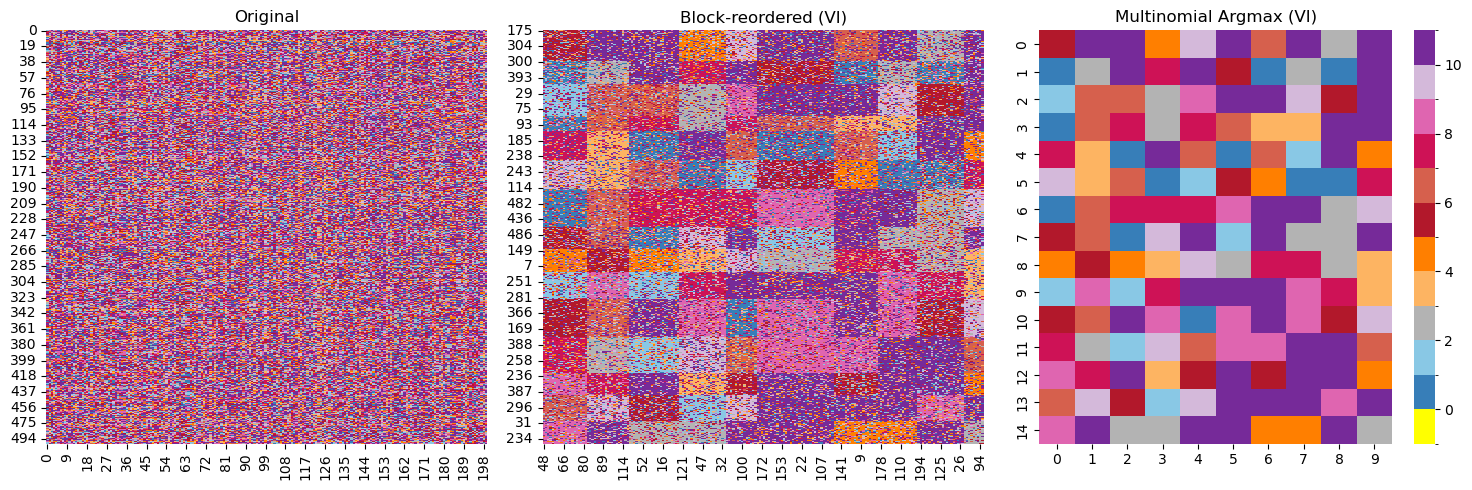

In [22]:
# Output of best model
sbm_trainer.filled_sbm.plt_blocks(plt_init=False)

In [23]:
# save trainer outputs and parameters
sbm_trainer.save_trainer_model(os.path.join(cwd, 'output', f'trainer.pickle'))

# save trained model
sbm_test.export_outputs_csv(os.path.join(cwd, 'output'), model_name='test_sbm_trained')

# show history
df = pd.DataFrame(sbm_trainer.model_history).sort_values('ICL')
display(df)

Saving model... to /Users/kevinlam/GitHub/PhD/cpl/cnsbm_mlcb/output/trainer.pickle


,iteration,ELBO,LogLik,KL-g,KL-h,KL-kl,ICL,Loglik,ICL_pen,g_entr,h_entr,K-eff,L-eff,model_version,strategy
0,10,-210215.58,-207326.69,1016.6191,382.54752,1489.7229,-212242.61,-207001.17,3905.9893,-973.902588,-361.546196,8,7,-1,base
1,14,-194964.52,-191103.62,1247.9502,382.54752,2230.391,-198502.83,-190585.42,6339.24,-1216.628158,-361.546196,13,7,1,spectral
2,6,-194866.36,-191141.72,1227.2223,382.54752,2114.8696,-198066.98,-190658.73,5852.59,-1194.111553,-361.546196,12,7,3,spectral
3,6,-177694.14,-173087.05,1227.2223,465.43372,2914.4387,-182399.08,-172406.92,8347.329,-1194.111553,-450.717835,12,10,4,spectral
4,6,-169808.39,-164702.86,1319.4292,465.43372,3320.6692,-175392.39,-163915.64,9735.096,-1290.934636,-450.717835,14,10,5,spectral
5,5,-165415.52,-160053.39,1366.1602,465.43372,3530.533,-171431.2,-159211.48,10428.979,-1340.016222,-450.717835,15,10,6,spectral
6,5,-165415.52,-160053.39,1366.1602,465.43372,3530.533,-171431.2,-159211.48,10428.979,-1340.016222,-450.717835,15,10,34,reset_min
7,5,-165415.52,-160053.39,1366.1602,465.43372,3530.533,-171431.2,-159211.48,10428.979,-1340.016222,-450.717835,15,10,56,reset_duplicates


# Environment Setup

In [ ]:
import sys, platform

print("Python version:", sys.version)
print("Platform:", platform.platform())

Python version: 3.10.17 | packaged by conda-forge | (main, Apr 10 2025, 22:23:34) [Clang 18.1.8 ]
Platform: macOS-15.4.1-arm64-arm-64bit


In [25]:
print("JAX version:", jax.__version__)
print("NumPy version:", np.__version__)

JAX version: 0.5.3
NumPy version: 2.2.6


In [26]:
!pip list

/opt/homebrew/Caskroom/miniforge/base/envs/cnsbm/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Package            Version
------------------ -----------
appnope            0.1.4
asttokens          3.0.0
comm               0.2.2
contourpy          1.3.2
cycler             0.12.1
debugpy            1.8.14
decorator          5.2.1
exceptiongroup     1.3.0
executing          2.2.0
fonttools          4.58.1
importlib_metadata 8.7.0
ipykernel          6.29.5
ipython            8.36.0
jax                0.5.3
jaxlib             0.5.3
jedi               0.19.2
joblib             1.5.1
jupyter_client     8.6.3
jupyter_core       5.8.1
kiwisolver         1.4.7
matplotlib         3.10.3
matplotlib-inline  0.1.7
ml-dtypes          0.5.1
munkres            1.1.4
nest_asyncio       1.6.0
numpy              2.2.6
opt_einsum         3.4.0
packaging          25.0
pandas             2.2.3
parso              0.8.4
patsy              1.0.1
pexpect            4.9.0
pickleshare        0.7.5
pillow             11.2.1
pip                25.1.1
platformdirs       4.3.8
prompt_toolkit     3.0.51
psutil  